## The Mountain Car Enviroment 2 (MCE)

LANDSCAPE: `0.3*np.sin(4*xs+np.sqrt(np.sin(10*xs)+2))+0.5`

Transition dynamics: `velocity += (action - 1) * self.force + (0.3 * np.cos(4*position + np.sqrt(np.sin(10*position) + 2)) * (4 + (5 * np.cos(10*position)) / (2 * np.sqrt(np.sin(10*position) + 2)))) * (-self.gravity)`

> So the slides presentation of the models are going to be avaible on lastminuteanalysis.com after the exam

In order to solve the mountain car problem we are going to use 
- the Q-learning algorithm

To obtain clearer insights from the data, we averaged the reward results over buckets of 500 episodes, utilizing the `SHOW_EVERY = 500 parameter`. This approach helps in reducing noise in our outcomes, allowing us to discern patterns more effectively. However, it might be insightful to also examine data in smaller episode buckets for a finer-grained analysis.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from typing import Optional

import gym
from gym import spaces
from gym.envs.classic_control import utils
from gym.error import DependencyNotInstalled

# video
from PIL import Image
import os
import cv2

# THE ENVIROMENT 2 (MCE)

In [2]:
class mce2(gym.Env):
    
    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 30,
    }

    def __init__(self, render_mode: Optional[str] = None, goal_velocity=0):
        self.min_position = -1.2
        self.max_position = 0.6
        self.max_speed = 0.07
        self.goal_position = 0.5
        self.goal_velocity = goal_velocity

        self.force = 0.001
        self.gravity = 0.0025

        self.low = np.array([self.min_position, -self.max_speed], dtype=np.float32)
        self.high = np.array([self.max_position, self.max_speed], dtype=np.float32)

        self.render_mode = render_mode

        self.screen_width = 800
        self.screen_height = 600
        self.screen = None
        self.clock = None
        self.isopen = True

        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(self.low, self.high, dtype=np.float32)

    def step(self, action: int):
        
        assert self.action_space.contains(
            action
        ), f"{action!r} ({type(action)}) invalid"

        position, velocity = self.state
        velocity += (action - 1) * self.force + (0.3 * np.cos(4*position + np.sqrt(np.sin(10*position) + 2)) * (4 + (5 * np.cos(10*position)) / (2 * np.sqrt(np.sin(10*position) + 2)))) * (-self.gravity)
        velocity = np.clip(velocity, -self.max_speed, self.max_speed)
        position += velocity
        position = np.clip(position, self.min_position, self.max_position)
        if position == self.min_position and velocity < 0:
            velocity = 0

        terminated = bool(
            position >= self.goal_position and velocity >= self.goal_velocity
        )
        reward = -1.0

        self.state = (position, velocity)
        if self.render_mode == "human":
            self.render()
        return np.array(self.state, dtype=np.float32), reward, terminated, False, {}

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        # Note that if you use custom reset bounds, it may lead to out-of-bound
        # state/observations.
        low, high = utils.maybe_parse_reset_bounds(options, -0.6, -0.4)
        self.state = np.array([self.np_random.uniform(low=low, high=high), 0])

        if self.render_mode == "human":
            self.render()
        return np.array(self.state, dtype=np.float32), {}

    def _height(self, xs):
        return 0.3*np.sin(4*xs+np.sqrt(np.sin(10*xs)+2))+0.5

    def render(self):
        if self.render_mode is None:
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
            from pygame import gfxdraw
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[classic_control]`"
            )

        if self.screen is None:
            pygame.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode(
                    (self.screen_width, self.screen_height)
                )
            else:  # mode in "rgb_array"
                self.screen = pygame.Surface((self.screen_width, self.screen_height))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        world_width = self.max_position - self.min_position
        scale = self.screen_width / world_width
        carwidth = 40
        carheight = 20

        self.surf = pygame.Surface((self.screen_width, self.screen_height))
        self.surf.fill((255, 255, 255))

        pos = self.state[0]

        xs = np.linspace(self.min_position, self.max_position, 100)
        ys = self._height(xs)
        xys = list(zip((xs - self.min_position) * scale, ys * scale))

        pygame.draw.aalines(self.surf, points=xys, closed=False, color=(0, 0, 0))

        clearance = 10

        l, r, t, b = -carwidth / 2, carwidth / 2, carheight, 0
        coords = []
        for c in [(l, b), (l, t), (r, t), (r, b)]:
            c = pygame.math.Vector2(c).rotate_rad(math.cos(3 * pos))
            coords.append(
                (
                    c[0] + (pos - self.min_position) * scale,
                    c[1] + clearance + self._height(pos) * scale,
                )
            )

        gfxdraw.aapolygon(self.surf, coords, (0, 0, 0))
        gfxdraw.filled_polygon(self.surf, coords, (0, 0, 0))

        for c in [(carwidth / 4, 0), (-carwidth / 4, 0)]:
            c = pygame.math.Vector2(c).rotate_rad(math.cos(3 * pos))
            wheel = (
                int(c[0] + (pos - self.min_position) * scale),
                int(c[1] + clearance + self._height(pos) * scale),
            )

            gfxdraw.aacircle(
                self.surf, wheel[0], wheel[1], int(carheight / 2.5), (128, 128, 128)
            )
            gfxdraw.filled_circle(
                self.surf, wheel[0], wheel[1], int(carheight / 2.5), (128, 128, 128)
            )

        flagx = int((self.goal_position - self.min_position) * scale)
        flagy1 = int(self._height(self.goal_position) * scale)
        flagy2 = flagy1 + 50
        gfxdraw.vline(self.surf, flagx, flagy1, flagy2, (0, 0, 0))

        gfxdraw.aapolygon(
            self.surf,
            [(flagx, flagy2), (flagx, flagy2 - 10), (flagx + 25, flagy2 - 5)],
            (204, 204, 0),
        )
        gfxdraw.filled_polygon(
            self.surf,
            [(flagx, flagy2), (flagx, flagy2 - 10), (flagx + 25, flagy2 - 5)],
            (204, 204, 0),
        )

        self.surf = pygame.transform.flip(self.surf, False, True)
        self.screen.blit(self.surf, (0, 0))
        if self.render_mode == "human":
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()

        elif self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def get_keys_to_action(self):
        # Control with left and right arrow keys.
        return {(): 1, (276,): 0, (275,): 2, (275, 276): 1}

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False


## Registration of the enviroment

In [3]:
ENV_NAME = "myenv-v2"
gym.register(
    id=ENV_NAME,
    entry_point='__main__:mce2',
)

## Looking at the enviroment

In [4]:
env = gym.make(ENV_NAME,render_mode="rgb_array")
env.reset()

frames_dir = 'testing'
os.makedirs(frames_dir, exist_ok=True)  # creates 'frames' directory if it doesn't exist
frame = np.array([])

episode = 0
idx_frames = 0
frame = env.render()
# Save frame as an image
img = Image.fromarray(frame)
img.save(os.path.join(frames_dir, f'frame_{episode}_{idx_frames}.png')) # saves the frame as an image

## Parameter/Methods definition and initialization

In [5]:
frames_dir = 'frames_level1'
os.makedirs(frames_dir, exist_ok=True)  # creates 'frames' directory if it doesn't exist
frame = np.array([])

# parameter setting
LEARNING_RATE = 0.2
DISCOUNT = 0.95
EPISODES = 25000
SHOW_EVERY = 500
FRAMES_EVERY = 24999

DISCRETE_OS_SIZE = [20] * len(env.observation_space.high)
discrete_os_win_size = (env.observation_space.high - env.observation_space.low)/DISCRETE_OS_SIZE

# Exploration settings
epsilon = 1  # not a constant, going to be decayed
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = EPISODES//2
epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)

# initialize q table
q_table = np.random.uniform(low=-2, high=0, size=(DISCRETE_OS_SIZE + [env.action_space.n]))

# For stats
ep_rewards = []
aggr_ep_rewards = {'ep': [], 'avg': [], 'max': [], 'min': []}

# discretization
def get_discrete_state(state):
    discrete_state = (state - env.observation_space.low)/discrete_os_win_size
    return tuple(discrete_state.astype(np.int64))  # we use this tuple to look up the 3 Q values for the available actions in the q-table

# epsilon greedy
def epsilon_greedy(q_table, discrete_state, epsilon):
    if np.random.random() > epsilon:
        action = np.argmax(q_table[discrete_state])
    else:
        action = np.random.randint(0, env.action_space.n)
    return action


## Training the agent - Q learning

In [6]:
for episode in range(EPISODES):
    # initialize
    state,_ = env.reset()
    discrete_state = get_discrete_state(state)
    done = False
    episode_reward = 0

    idx_frames = 0

    # episode loop
    while not done:

        # epsilon greedy
        action = epsilon_greedy(q_table, discrete_state, epsilon)
        # new_state and reward
        new_state, reward, done, _, _ = env.step(action)
        # duscretization
        new_discrete_state = get_discrete_state(new_state)
        # update reward
        episode_reward += reward

        if not done:
            max_future_q = np.max(q_table[new_discrete_state])
            current_q = q_table[discrete_state + (action,)]
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            q_table[discrete_state + (action,)] = new_q
        elif new_state[0] >= env.goal_position: # Simulation ended (for any reson) - if goal position is achived - update Q value with reward directly
            q_table[discrete_state + (action,)] = 0

        discrete_state = new_discrete_state

        # truncated
        if episode_reward <= -200 :
            done = True

        # VIDEO
        if episode == FRAMES_EVERY :
            frame = env.render()
            # Save frame as an image
            img = Image.fromarray(frame)
            img.save(os.path.join(frames_dir, f'frame_{episode}_{idx_frames}.png')) # saves the frame as an image
            idx_frames += 1

        if episode % SHOW_EVERY == 0:
            env.render()


    # epsilon decay
    if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
        epsilon -= epsilon_decay_value

    # Stats for the episode 
    ep_rewards.append(episode_reward)
    if not episode % SHOW_EVERY:
        if len(ep_rewards) < SHOW_EVERY:
            average_reward = sum(ep_rewards) / len(ep_rewards)
        else:
            average_reward = sum(ep_rewards[-SHOW_EVERY:]) / SHOW_EVERY
        aggr_ep_rewards['ep'].append(episode)
        aggr_ep_rewards['avg'].append(average_reward)
        aggr_ep_rewards['max'].append(max(ep_rewards[-SHOW_EVERY:]))
        aggr_ep_rewards['min'].append(min(ep_rewards[-SHOW_EVERY:]))
        print(f'Episode: {episode:>5d}, average reward: {average_reward:>4.1f}, current epsilon: {epsilon:>1.2f}')

        average_r_q = aggr_ep_rewards['avg'] # for plot together
    
    if episode % SHOW_EVERY == 0:
        render = True
    else:
        render = False

env.close()

/Users/Giammi/miniconda3/envs/reinforcement/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode:     0, average reward: -200.0, current epsilon: 1.00
Episode:   500, average reward: -200.0, current epsilon: 0.96
Episode:  1000, average reward: -200.0, current epsilon: 0.92
Episode:  1500, average reward: -200.0, current epsilon: 0.88
Episode:  2000, average reward: -200.0, current epsilon: 0.84
Episode:  2500, average reward: -200.0, current epsilon: 0.80
Episode:  3000, average reward: -200.0, current epsilon: 0.76
Episode:  3500, average reward: -200.0, current epsilon: 0.72
Episode:  4000, average reward: -200.0, current epsilon: 0.68
Episode:  4500, average reward: -200.0, current epsilon: 0.64
Episode:  5000, average reward: -200.0, current epsilon: 0.60
Episode:  5500, average reward: -200.0, current epsilon: 0.56
Episode:  6000, average reward: -199.9, current epsilon: 0.52
Episode:  6500, average reward: -200.0, current epsilon: 0.48
Episode:  7000, average reward: -200.0, current epsilon: 0.44
Episode:  7500, average reward: -199.3, current epsilon: 0.40
Episode:

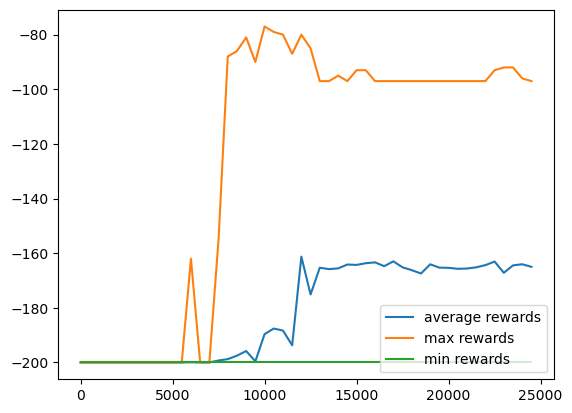

In [7]:
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label="average rewards")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label="max rewards")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label="min rewards")
plt.legend(loc=4)
plt.show()